In [2]:
import pandas as pd
import numpy as np
#import umap
from scipy.stats import sem
import seaborn as sns
from copy import deepcopy
import matplotlib.pyplot as plt
from skbio.diversity.alpha import faith_pd
from skbio.diversity.alpha import shannon
from scipy.interpolate import CubicSpline
from scipy.stats import pearsonr, spearmanr
from scipy.stats import linregress
from sklearn.metrics import r2_score
from skbio import TreeNode
#from scipy.integrate import simpson
from scipy.spatial.distance import pdist
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from skbio.stats.distance import permanova
from skbio import DistanceMatrix
import matplotlib.transforms as transforms

# Plot muribaculaceae

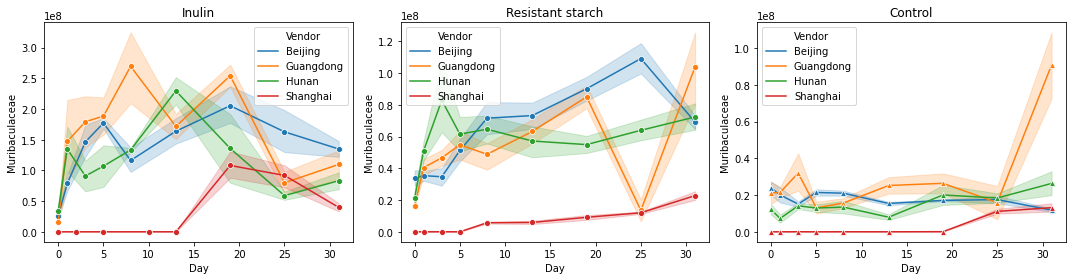

In [9]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_absolute_abundance_species.csv',index_col=0)
df = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

fig, ax=plt.subplots(nrows=1,ncols=3,figsize=(15,4))
for k,diet in enumerate(['Inulin','Resistant starch','Control']):
    if diet=='Control':
        _ = sns.lineplot(x='Day', y='Muribaculaceae', hue='Vendor',  data=df[df.Diet==diet], ax=ax[k], ci=68, marker='^')
    else:
        _ = sns.lineplot(x='Day', y='Muribaculaceae', hue='Vendor',  data=df[df.Diet==diet], ax=ax[k], ci=68, marker='o')
    _ = ax[k].set_title(diet)
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("muribaculaceae_dynamics.svg", format="svg")

# Plot SCFAs

In [17]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_scfa = pd.read_csv('../../our_data/SCFA.csv',index_col=0)
df = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df = df.loc[df.Diet=='Inulin',['MiceID','Vendor','Day','Total']]
df = pd.pivot_table(df, index=['MiceID','Vendor'], columns='Day', values='Total')
df['FC'] = [np.max(df.loc[idx,[0,1,2,3,5,8,10,13,19,25,31]])/df.loc[idx,0] for idx in df.index]
df = df[['FC']].reset_index()
df = df.groupby('Vendor').agg(np.mean)
df

Day,FC
Vendor,
Beijing,3.303235
Guangdong,3.903416
Hunan,4.497700
Shanghai,4.207251


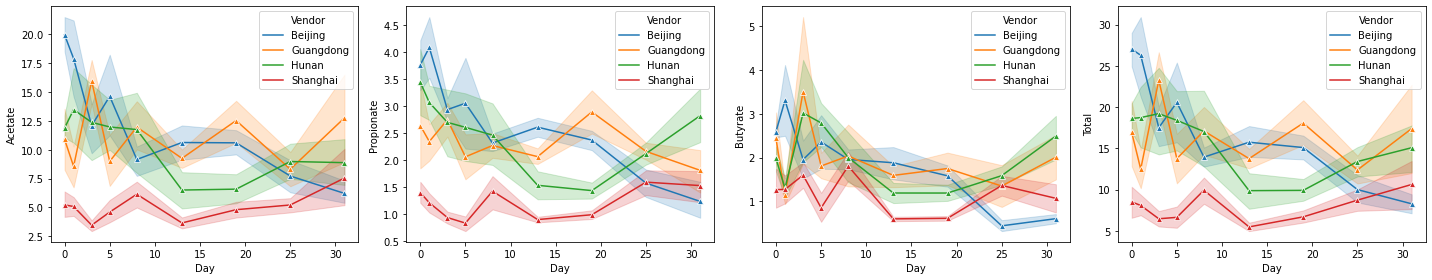

In [2]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_scfa = pd.read_csv('../../our_data/SCFA.csv',index_col=0)
df_scfa = df_scfa.clip(lower=0)
df = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')

fig, ax=plt.subplots(nrows=1,ncols=4,figsize=(20,4))
for k,scfa in enumerate(['Acetate','Propionate','Butyrate','Total']):
    _ = sns.lineplot(x='Day', y=scfa, hue='Vendor',  data=df[df.Diet=='Control'], ax=ax[k], ci=68, marker='^')
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scfa_dynamics_inulin.svg", format="svg")

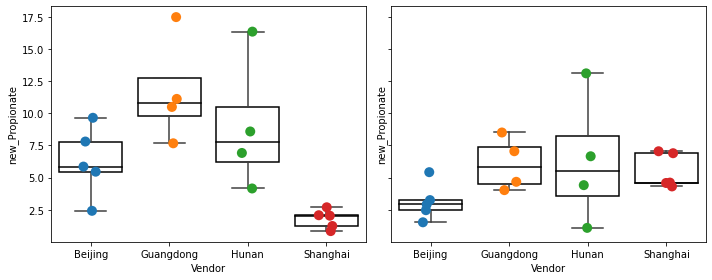

In [49]:
fig, ax=plt.subplots(nrows=1,ncols=2,figsize=(10,4),sharey=True,sharex=True)
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
}
new_propionate = []
for index in df.index:
    miceid = df.loc[index,'MiceID']
    baseline = list(df.loc[(df.MiceID==miceid)&(df.Day==0),'Propionate'])[0]
    new_propionate.append(df.loc[index,'Propionate']-baseline)
df['new_Propionate'] = new_propionate
_ = sns.boxplot(x='Vendor', y='new_Propionate', data=df[(df.Diet=='Inulin')&(df.Day==5)], ax=ax[0], showfliers=False, **PROPS)
_ = sns.stripplot(x='Vendor', y='new_Propionate', data=df[(df.Diet=='Inulin')&(df.Day==5)], ax=ax[0], jitter=True, size=10)
_ = sns.boxplot(x='Vendor', y='new_Propionate', data=df[(df.Diet=='Inulin')&(df.Day==31)], ax=ax[1], showfliers=False, **PROPS)
_ = sns.stripplot(x='Vendor', y='new_Propionate', data=df[(df.Diet=='Inulin')&(df.Day==31)], ax=ax[1], jitter=True, size=10)
    
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("propionate_day5_day31.svg", format="svg")

# Phylum level difference

In [69]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_meta = df_meta[df_meta.Day==0]
df_bac = pd.read_csv('../../our_data/16S_relative_abundance_asv.csv',index_col=0)
df_tax = pd.read_csv('../../our_data/taxonomy.csv')
df_bac = pd.merge(df_bac, df_tax[['ASV','Phylum']].set_index('ASV'), left_index=True, right_index=True, how='left').fillna('<not present>')
df_bac = df_bac.groupby('Phylum').agg(np.sum).T
df_bac = df_bac[['Bacteroidota','Firmicutes']]
df_bac['BFR'] = df_bac.Bacteroidota/df_bac.Firmicutes
df_bac = pd.merge(df_bac, df_meta[['Vendor']], left_index=True, right_index=True, how='inner')
df_bac.index.name='SampleID'
df_bac['Feature'] = 'Feature'
df_bac['BFS'] = df_bac.Bacteroidota+df_bac.Firmicutes

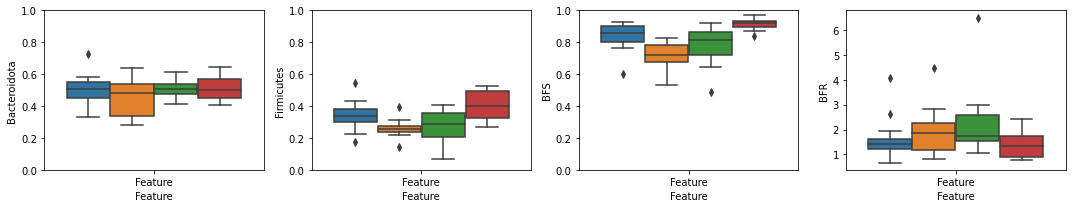

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,3), sharex=True)

for k,f in enumerate(['Bacteroidota','Firmicutes','BFS','BFR']):
    _ = sns.boxplot(x='Feature', y=f, hue='Vendor', data=df_bac, ax=ax[k])
    
    # get statistical test P value
    
    
    if k!=3:
        _ = ax[k].set_ylim([0,1])
    _  =ax[k].legend().remove()
        
plt.tight_layout()

# Plot UMAP (separate vendors)

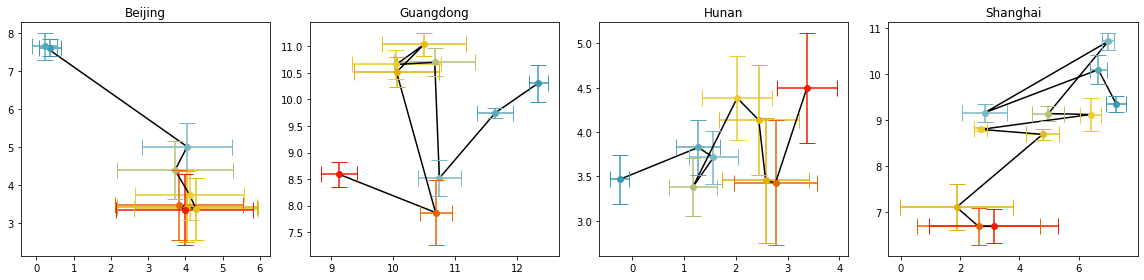

In [80]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_relative_abundance_asv.csv',index_col=0).T
asvs = list(df_bac.columns)
df = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

colors = {0:'#3B9AB2',1:'#59A8B8',2:'#78B7C5',3:'#78B7C5',5:'#B1C177',8:'#EBCC2A',10:'#EBCC2A',13:'#E5BD15',19:'#E1AF00',25:'#E96400',31:'#F21A00'}
for k,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    df_tmp = df[df.Vendor==vendor]
    fit = umap.UMAP(random_state=0)
    u = fit.fit_transform(df_tmp[asvs].values)
    coef = pd.DataFrame(u, index=df_tmp.index, columns=['UMAP 1','UMAP 2'])
    df_coef = pd.merge(df_meta, coef, left_index=True, right_index=True, how='inner').sort_values(by='Day')
    umap_mean = df_coef.groupby(['Day']).agg(np.mean)
    umap_se = df_coef.groupby(['Day']).agg(sem)
    ax[k].plot(umap_mean['UMAP 1'], umap_mean['UMAP 2'], 'k-')  
    for day in [0,1,2,3,5,8,10,13,19,25,31]:
        if day in list(umap_mean.index):
            ax[k].plot(umap_mean.loc[day,'UMAP 1'], umap_mean.loc[day,'UMAP 2'], 'o', color=colors[day], markerfacecolor=colors[day])
            ax[k].errorbar(umap_mean.loc[day,'UMAP 1'], umap_mean.loc[day,'UMAP 2'], 
                           yerr=umap_se.loc[day,'UMAP 2'], xerr=umap_se.loc[day,'UMAP 1'],
                           fmt='', capsize=8, barsabove=False, capthick=None, ecolor=colors[day])
    ax[k].set_title(vendor)
    
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("microbiome_trajectory_umap_vendor_separate.svg", format="svg")

# Plot UMAP (combine all vendors)

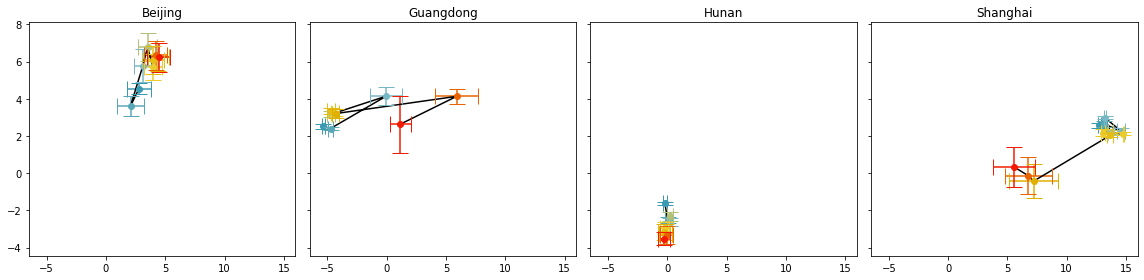

In [81]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_relative_abundance_asv.csv',index_col=0).T
asvs = list(df_bac.columns)
df = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,4), sharex=True, sharey=True)

colors = {0:'#3B9AB2',1:'#59A8B8',2:'#78B7C5',3:'#78B7C5',5:'#B1C177',8:'#EBCC2A',10:'#EBCC2A',13:'#E5BD15',19:'#E1AF00',25:'#E96400',31:'#F21A00'}
fit = umap.UMAP(random_state=0)
u = fit.fit_transform(df[asvs].values)
coef = pd.DataFrame(u, index=df.index, columns=['UMAP 1','UMAP 2'])
df_coef = pd.merge(df_meta, coef, left_index=True, right_index=True, how='inner').sort_values(by='Day')
for k,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    df_tmp = df_coef[df_coef.Vendor==vendor]
    umap_mean = df_tmp.groupby(['Day']).agg(np.mean)
    umap_se = df_tmp.groupby(['Day']).agg(sem)
    ax[k].plot(umap_mean['UMAP 1'], umap_mean['UMAP 2'], 'k-')  
    for day in [0,1,2,3,5,8,10,13,19,25,31]:
        if day in list(umap_mean.index):
            ax[k].plot(umap_mean.loc[day,'UMAP 1'], umap_mean.loc[day,'UMAP 2'], 'o', color=colors[day], markerfacecolor=colors[day])
            ax[k].errorbar(umap_mean.loc[day,'UMAP 1'], umap_mean.loc[day,'UMAP 2'], 
                           yerr=umap_se.loc[day,'UMAP 2'], xerr=umap_se.loc[day,'UMAP 1'],
                           fmt='', capsize=8, barsabove=False, capthick=None, ecolor=colors[day])
    ax[k].set_title(vendor)
    
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("microbiome_trajectory_umap_vendor_combined.svg", format="svg")

# Plot correlation between alpha diversity and SCFA

<ipython-input-15-51cb07dd37e1>:3: RuntimeWarning: divide by zero encountered in log2
  df_alpha_diversity = -np.sum(df_bac*np.log2(df_bac)).to_frame()


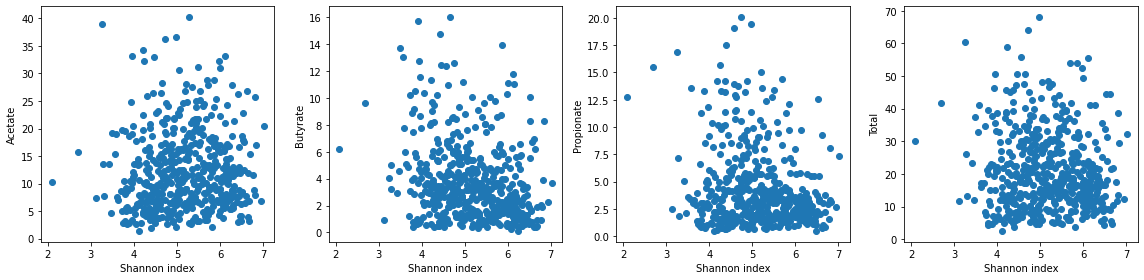

In [15]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_relative_abundance_asv.csv',index_col=0)
df_alpha_diversity = -np.sum(df_bac*np.log2(df_bac)).to_frame()
df_alpha_diversity.columns = ['AlphaDiversity']
df_scfa = pd.read_csv('../../our_data/SCFA.csv',index_col=0)
df = pd.merge(df_scfa, df_alpha_diversity, left_index=True, right_index=True, how='inner')

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,4), sharex=True)

for k,scfa in enumerate(['Acetate','Butyrate','Propionate','Total']):
    _ = ax[k].scatter(df['AlphaDiversity'], df[scfa], marker='o')
    _ = ax[k].set_xlabel('Shannon index')
    _ = ax[k].set_ylabel(scfa)
    
plt.tight_layout()

# Plot dynamics of iso-butyrate, iso-valerate, and valerate

In [ ]:
#df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
#df_scfa = pd.read_csv('../../our_data/SCFA.csv',index_col=0)
#df_scfa = df_scfa[['Iso-butyrate','Iso-valerate','Valerate']]
# df_scfa = df_scfa.clip(lower=0)
# df = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')

# fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(8,8), sharex=True, sharey=True)

# for k1,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
#     df_tmp = df[(df.Vendor==vendor)]
#     for k2,scfa in enumerate(['Iso-butyrate','Iso-valerate','Valerate']):
#         _ = sns.lineplot(x='Day', y=scfa, hue='Diet', data=df_tmp, ci=68, marker='o', ax=ax[k1,k2])
#         ax[k1,k2].legend().remove()
#         ax[k1,k2].set_ylabel(vendor)
#         if k1 ==0:
#             ax[k1,k2].set_title(scfa)
#         ax[k1,k2].set_yticks([0,0.4,0.8])
#         ax[k1,k2].set_xticks([0,5,10,15,20,25,30])
# plt.tight_layout()

# plt.rcParams['svg.fonttype'] = 'none'
# fig.savefig("dynamics_of_other_scfa.svg", format="svg")

# Compare inulin and resistant starch stimulation

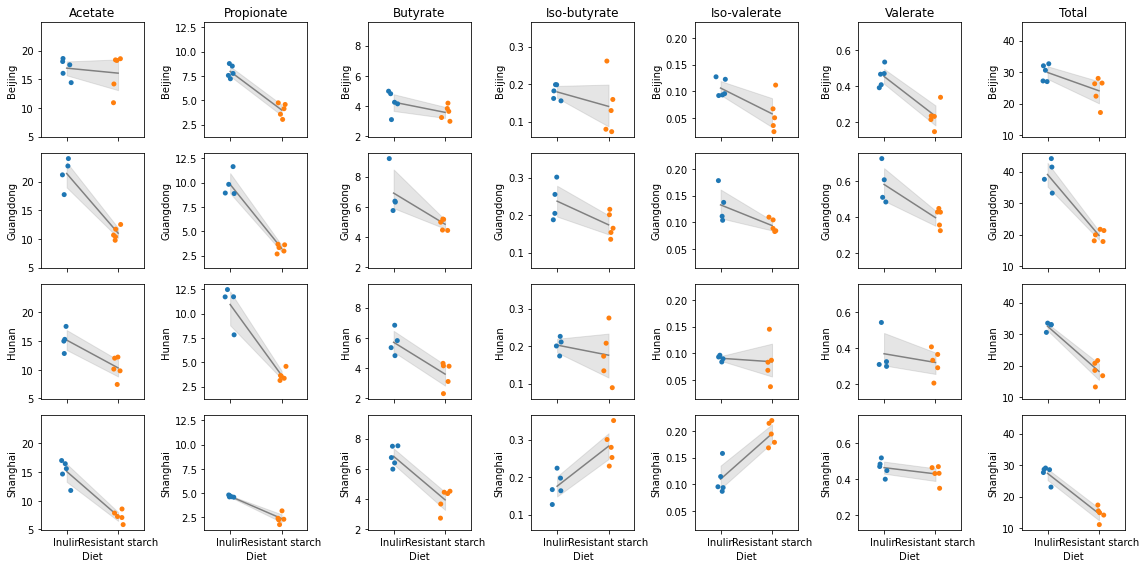

In [41]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_scfa = pd.read_csv('../../our_data/SCFA.csv',index_col=0)
df_scfa = df_scfa.clip(lower=0)
df = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')

# calculate area under the curve
lines = []
for miceid in set(df.MiceID):
    vendor = list(set(df.loc[df.MiceID==miceid,'Vendor']))
    assert len(vendor)==1
    vendor = vendor[0]
    for diet in ['Inulin','Resistant starch']:
        df_tmp = df[(df.MiceID==miceid)&(df.Diet==diet)].sort_values(by='Day')
        if len(df_tmp) != 0:
            for scfa in df_scfa.columns:
                x = df_tmp.Day
                y = df_tmp[scfa]
                area = simpson(y,x)/np.max(x)
                lines.append([miceid,vendor,diet,scfa,area])
df_area = pd.DataFrame(lines, columns=['MiceID','Vendor','Diet','SCFA','Mean'])

fig, ax = plt.subplots(nrows=4, ncols=len(df_scfa.columns), figsize=(16,8), sharex=True, sharey='col')

for k1,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    for k2,scfa in enumerate(df_scfa.columns):
        df_tmp = df_area[(df_area.Vendor==vendor)&(df_area.SCFA==scfa)].sort_values('Diet')
        _ = sns.lineplot(x='Diet',y='Mean',data=df_tmp, ax=ax[k1,k2], color='gray')
        _ = sns.stripplot(x='Diet', y='Mean', data=df_tmp, ax=ax[k1,k2])
        ax[k1,k2].set_ylabel(vendor)
        if k1==0:
            ax[k1,k2].set_title(scfa)
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("comparison_inulin_vs_rs.svg", format="svg")

# Compare SCFA level at initial, peak and final

In [42]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_scfa = pd.read_csv('../../our_data/SCFA.csv',index_col=0)
df_scfa = df_scfa.clip(lower=0)
df = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')

# calculate area under the curve
lines = []
for miceid in set(df.MiceID):
    vendor = list(set(df.loc[df.MiceID==miceid,'Vendor']))
    assert len(vendor)==1
    vendor = vendor[0]
    for diet in ['Inulin','Resistant starch']:
        df_tmp = df[(df.MiceID==miceid)&(df.Diet==diet)].sort_values(by='Day')
        if len(df_tmp) != 0:
            for scfa in df_scfa.columns:
                y = list(df_tmp[scfa])
                inity = y[0]
                peaky = np.max(y)
                finaly = y[-1]
                lines.append([miceid,vendor,diet,scfa,inity, peaky, finaly])
df = pd.DataFrame(lines, columns=['MiceID','Vendor','Diet','SCFA','InitConc','PeakConc','FinalConc'])

for diet in ['Inulin','Resistant starch']:
    for vendor in ['Beijing','Guangdong','Hunan','Shanghai']:
        df_tmp = df[(df.Vendor==vendor) & (df.Diet==diet) & (df.SCFA=='Total')]
        fracOfPeak = np.mean(df_tmp.FinalConc/df_tmp.PeakConc)
        dropby = np.mean((df_tmp.PeakConc-df_tmp.FinalConc)/df_tmp.PeakConc)
        fracOfInit = np.mean(df_tmp.FinalConc/df_tmp.InitConc)
        print(diet, vendor, fracOfPeak, fracOfInit, dropby)

Inulin Beijing 0.6431989359696245 2.0425206529187525 0.3568010640303755
Inulin Guangdong 0.6296615948189852 2.2748909846509906 0.3703384051810147
Inulin Hunan 0.6066312162800261 3.2772335853027927 0.3933687837199739
Inulin Shanghai 0.6486224200430801 2.3329380961194315 0.35137757995691976
Resistant starch Beijing 0.9587670355971689 1.9834639965906917 0.041232964402831175
Resistant starch Guangdong 0.4090342994083388 1.07645940056657 0.5909657005916612
Resistant starch Hunan 0.7805753081557981 1.5102306165713206 0.2194246918442019
Resistant starch Shanghai 0.6615588340181142 1.4882694809277321 0.33844116598188567


# Compare vendor difference at initial peak and final

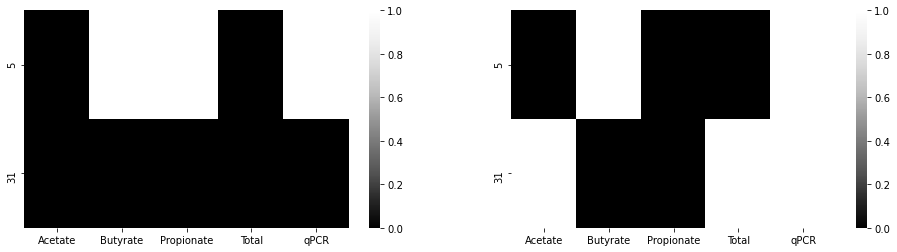

In [53]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_scfa = pd.read_csv('../../our_data/SCFA.csv',index_col=0)
df_scfa = df_scfa.clip(lower=0)
df_qpcr = pd.read_csv('../../our_data/qPCR.csv', index_col=0).rename({'Value':'qPCR'}, axis=1)
df = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df = pd.merge(df, df_qpcr, left_index=True, right_index=True, how='inner')

lines = []
for day in [5,31]:
    for diet in ['Inulin','Resistant starch']:
        df_tmp = df[df.Diet==diet]
        for scfa in ['Acetate','Propionate','Butyrate','Total','qPCR']:
            df_tmp2 = pd.pivot_table(df_tmp[['MiceID','Day','Vendor',scfa]], index=['MiceID','Vendor'], columns='Day', values=scfa).reset_index()
            df_tmp2['Delta'] = df_tmp2[day]-df_tmp2[0]
            df_tmp2 = df_tmp2[df_tmp2.Delta.notnull()]
            dm = pdist(np.asarray(df_tmp2['Delta'].values).reshape(-1,1), metric='minkowski')
            DM = DistanceMatrix(dm,list(df_tmp2.MiceID))
            stats = permanova(DM, grouping=list(df_tmp2.Vendor), permutations=999)
            lines.append([day,diet,scfa,stats['p-value']])
df2 = pd.DataFrame(lines, columns=['Day','Diet','SCFA','P'])
df2['P'] = multipletests(df2['P'],method='fdr_bh')[1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

df2_A = pd.pivot_table(df2[df2.Diet=='Inulin'], index='Day', columns='SCFA', values='P')
df2_A = df2_A<0.05
_ = sns.heatmap(df2_A.values, ax=ax[0], cmap="Greys_r", xticklabels=df2_A.columns, yticklabels=df2_A.index)

df2_B = pd.pivot_table(df2[df2.Diet=='Resistant starch'], index='Day', columns='SCFA', values='P')
df2_B = df2_B<0.05
_ = sns.heatmap(df2_B.values, ax=ax[1], cmap="Greys_r", xticklabels=df2_B.columns, yticklabels=df2_B.index)
fig.savefig("scfa_difference_at_day0_5_31.svg", format="svg")

# Individualized responses of bacteria

In [24]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_absolute_abundance_species.csv', index_col=0)
df = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

lines = []
for diet in ['Inulin','Resistant starch']:
    df_tmp = df[((df.Day==0)|(df.Day==31)) & (df.Diet==diet)]
    for bac in df_bac.columns:
        df_tmp2 = pd.pivot_table(df_tmp[['MiceID','Day','Vendor',bac]], index=['MiceID','Vendor'], columns='Day', values=bac).reset_index()
        df_tmp2 = df_tmp2[df_tmp2.notnull()]
        df_tmp2['Delta'] = df_tmp2[31]-df_tmp2[0]
        dm = pdist(np.asarray(df_tmp2[['Delta']].values).reshape(-1,1), metric='minkowski')
        DM = DistanceMatrix(dm,list(df_tmp2.MiceID))
        stats = permanova(DM, grouping=list(df_tmp2.Vendor), permutations=999)
        lines.append([diet,bac,stats['p-value']])
df2 = pd.DataFrame(lines, columns=['Diet','Species','P'])
df2['P_adj'] = multipletests(df2['P'],method='fdr_bh')[1]
df2.head()

,Diet,Species,P,P_adj
0,Inulin,A2,0.001,0.002815
1,Inulin,ASF356,0.012,0.025690
2,Inulin,Acetatifactor,0.002,0.005153
3,Inulin,Acetatifactor-muris,0.865,1.000000
4,Inulin,Acidovorax,0.001,0.002815


In [25]:
len(df2[(df2.Diet=='Inulin')&(df2.P_adj<0.05)])/len(df2[df2.Diet=='Inulin'])

0.506578947368421

In [26]:
len(df2[(df2.Diet=='Resistant starch')&(df2.P_adj<0.05)])/len(df2[df2.Diet=='Resistant starch'])

0.5197368421052632

# Identify inulin responders based on pre-post changes

In [33]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_absolute_abundance_species.csv', index_col=0)
df = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')

lines = []
for diet in ['Inulin','Resistant starch']:
    df_tmp = df[((df.Day==0)|(df.Day==31)) & (df.Diet==diet)]
    for bac in df_bac.columns:
        df_tmp2 = pd.pivot_table(df_tmp[['MiceID','Day','Vendor',bac]], index=['MiceID','Vendor'], columns='Day', values=bac).reset_index()
        df_tmp2 = df_tmp2[df_tmp2.notnull()]
        df_tmp2 = df_tmp2.loc[:, (df_tmp2 != 0).any(axis=0)]
        if 0 in list(df_tmp2.columns) and 31 in list(df_tmp2.columns):
            pvalue = mannwhitneyu(df_tmp2[0], df_tmp2[31])[1]
            fc = np.mean(df_tmp2[31])/np.mean(df_tmp2[0])
            lines.append([diet,bac, fc, pvalue])
df2 = pd.DataFrame(lines, columns=['Diet','Species','FC','P'])
df2['P_adj'] = multipletests(df2['P'],method='fdr_bh')[1]
df2.head()

,Diet,Species,FC,P,P_adj
0,Inulin,A2,5.665587,0.377512,0.471854
1,Inulin,ASF356,3.348645,0.144441,0.324729
2,Inulin,Acetatifactor,1.931009,0.339604,0.469343
3,Inulin,Acetatifactor-muris,4.968938,0.176805,0.334085
4,Inulin,Acutalibacter-muris,4.444266,0.040268,0.172136


In [35]:
df2[(df2.Diet=='Inulin')&(df2.FC>1)&(df2.P_adj<0.05)]

,Diet,Species,FC,P,P_adj
6,Inulin,Akkermansia-muciniphila,24.611947,0.000016,0.000815
28,Inulin,Bifidobacterium-choerinum,32.746374,0.001059,0.016306
44,Inulin,Clostridia-UCG-014,12.309698,0.000053,0.001909
100,Inulin,Monoglobus,1.151740,0.000407,0.009645
102,Inulin,Muribaculaceae,4.926090,0.000004,0.000338
117,Inulin,Parasutterella,2.418674,0.001547,0.021660


# Plot Akkermansia muciniphila and Bacteroides uniformis between vendors in baseline

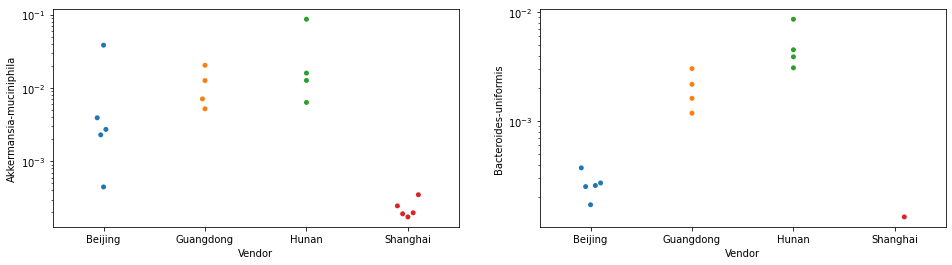

In [40]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_relative_abundance_species.csv', index_col=0)
df = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')
df = df[(df.Day==0)&(df.Diet=='Inulin')]
df = df[['MiceID','Vendor','Akkermansia-muciniphila','Bacteroides-uniformis']]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
_ = sns.swarmplot(x='Vendor', y='Akkermansia-muciniphila', data=df, ax=ax[0])
_ = sns.swarmplot(x='Vendor', y='Bacteroides-uniformis', data=df, ax=ax[1])
_ = ax[0].set_yscale('log')
_ = ax[1].set_yscale('log')

# Plot dyanmics of Parabacteroides distasonis and Bacteroides uniformis

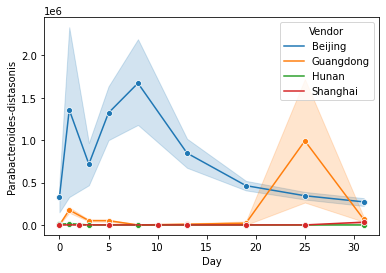

In [13]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_absolute_abundance_species.csv',index_col=0)
df_bac = df_bac[['Parabacteroides-distasonis']]
df = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')
df = df[df.Diet=='Inulin']
ax = sns.lineplot(x='Day', y='Parabacteroides-distasonis', hue='Vendor', data=df, ci=68, marker='o')
# ax.set_yscale('log')
# ax.set_ylim([1,1e7])

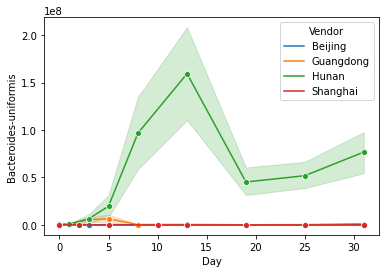

In [16]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_absolute_abundance_species.csv',index_col=0)
df_bac = df_bac[['Bacteroides-uniformis']]
df = pd.merge(df_meta, df_bac, left_index=True, right_index=True, how='inner')
df = df[df.Diet=='Inulin']
ax = sns.lineplot(x='Day', y='Bacteroides-uniformis', hue='Vendor', data=df, ci=68, marker='o')
#ax.set_yscale('log')
# ax.set_ylim([1,1e7])

# Scatterplot of unclassified Parabacteroides and propionate production rate

In [4]:
df_meta = pd.read_csv('../../our_data/meta_data.csv',index_col=0)
df_bac = pd.read_csv('../../our_data/16S_absolute_abundance_species.csv',index_col=0)
species = list(df_bac.columns)
df_scfa = pd.read_csv('../../our_data/SCFA.csv', index_col=0)
df_scfa = df_scfa[['Propionate']]

# calculate SCFA derivatives
df_scfa_meta = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_scfa_deriv_meta = deepcopy(df_scfa_meta)
df_scfa_deriv_meta = df_scfa_deriv_meta.rename({'Propionate':'Propionate_deriv'}, axis=1)
for mouse in set(df_scfa_deriv_meta.MiceID):
    curr_df = df_scfa_meta[df_scfa_meta.MiceID==mouse].sort_values(by='Day')
    xdata = np.array(curr_df['Day'])
    ydata = np.array(curr_df['Propionate'])
    cs = CubicSpline(xdata, ydata)
    csd1 = cs.derivative(nu=1)
    ydata_d1 = csd1(xdata)
    df_scfa_deriv_meta.loc[df_scfa_deriv_meta.MiceID==mouse, 'Propionate_deriv'] = ydata_d1
df = pd.merge(df_scfa_deriv_meta, df_scfa, left_index=True, right_index=True, how='inner')
df = pd.merge(df, df_bac, left_index=True, right_index=True, how='inner')

## inulin

In [5]:
df_inulin = df[df.Diet=='Inulin']
df_0 = df_inulin[df_inulin.Day==0]
df_0 = df_0.loc[:, (df_0 != df_0.iloc[0]).any()] 
df_1 = df_inulin[df_inulin.Day>0]
df_1 = df_1.loc[:, (df_1 != df_1.iloc[0]).any()]

# correlate baseline microbiota with derivative
corr_baseline_ppa_deriv = []
for s in species:
    if s in list(df_0.columns):
        xdata = np.asarray(df_0[s])
        ydata = np.asarray(df_0['Propionate_deriv'])
        slope, intercept, r_value, p_value, std_err = linregress(x=xdata, y=ydata)
        ydata_prediction = intercept+ slope*xdata
        pcorr = pearsonr(xdata, ydata)[0]
        scorr = spearmanr(xdata, ydata)[0]
        r2 = r2_score(ydata, ydata_prediction)
        corr_baseline_ppa_deriv.append([s, pcorr, scorr, r2])
df_corr_baseline_ppa_deriv = pd.DataFrame(corr_baseline_ppa_deriv, columns=['Species','Pearson','Spearman','R2'])
df_corr_baseline_ppa_deriv.sort_values(by='R2', ascending=False).head()

,Species,Pearson,Spearman,R2
145,Parabacteroides,0.710463,0.455108,0.504758
202,mouse-gut-metagenome,0.671433,0.608616,0.450822
148,Parabacteroides-merdae,0.631874,0.066597,0.399264
80,Enterobacteriaceae,0.584308,0.352347,0.341416
84,Erysipelatoclostridium-ramosum,0.577562,0.397360,0.333578


0.7104632159237145 0.000952322940705558
0.7104632159237145 0.45510835913312697 0.5047579811806664
0.21016763727665655 0.014794910535951777
0.21016763727665655 0.04737712426199146 0.044170435758452364


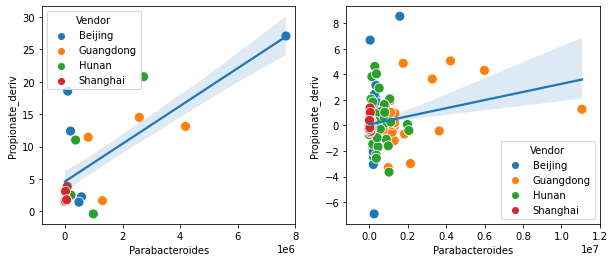

In [9]:
# scatterplot
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

# day = 0
_ = sns.scatterplot(x='Parabacteroides', y='Propionate_deriv', hue='Vendor', data=df_0, ax=ax[0], s=100)
p = sns.regplot(x='Parabacteroides', y='Propionate_deriv', data=df_0, ax=ax[0], scatter=False, ci=68)
xdata = np.asarray(df_0.Parabacteroides)
ydata = np.asarray(df_0.Propionate_deriv)
slope, intercept, r_value, p_value, std_err = linregress(xdata, ydata)
print(r_value, p_value)
ydata_prediction = intercept+ slope*xdata
pcorr = pearsonr(xdata, ydata)[0]
scorr = spearmanr(xdata, ydata)[0]
r2 = r2_score(ydata, ydata_prediction)
print(pcorr, scorr, r2)
_ = ax[0].set_xlim([-8e5, 8e6])

# day > 0
_ = sns.scatterplot(x='Parabacteroides', y='Propionate_deriv', hue='Vendor', data=df_1, ax=ax[1], s=100)
p = sns.regplot(x='Parabacteroides', y='Propionate_deriv', data=df_1, ax=ax[1], scatter=False, ci=68)
xdata = np.asarray(df_1.Parabacteroides)
ydata = np.asarray(df_1.Propionate_deriv)
slope, intercept, r_value, p_value, std_err = linregress(xdata, ydata)
print(r_value, p_value)
ydata_prediction = intercept+ slope*xdata
pcorr = pearsonr(xdata, ydata)[0]
scorr = spearmanr(xdata, ydata)[0]
r2 = r2_score(ydata, ydata_prediction)
print(pcorr, scorr, r2)
_ = ax[1].set_xlim([-1.2e6, 1.2e7])

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("correlation_baseline_Parabacteroides_propionate_production_rate.svg", format="svg")

## Resistant starch

In [15]:
df_rs = df[df.Diet=='Resistant starch']
df_0 = df_rs[df_rs.Day==0]
df_0 = df_0.loc[:, (df_0 != df_0.iloc[0]).any()] 
df_1 = df_rs[df_rs.Day>0]
df_1 = df_1.loc[:, (df_1 != df_1.iloc[0]).any()]

# correlate baseline microbiota with derivative
corr_baseline_ppa_deriv = []
for s in species:
    if s in list(df_0.columns):
        xdata = np.asarray(df_0[s])
        ydata = np.asarray(df_0['Propionate_deriv'])
        slope, intercept, r_value, p_value, std_err = linregress(x=xdata, y=ydata)
        ydata_prediction = intercept+ slope*xdata
        pcorr = pearsonr(xdata, ydata)[0]
        scorr = spearmanr(xdata, ydata)[0]
        r2 = r2_score(ydata, ydata_prediction)
        corr_baseline_ppa_deriv.append([s, pcorr, scorr, r2])
df_corr_baseline_ppa_deriv = pd.DataFrame(corr_baseline_ppa_deriv, columns=['Species','Pearson','Spearman','R2'])
df_corr_baseline_ppa_deriv.sort_values(by='R2', ascending=False).head()

,Species,Pearson,Spearman,R2
39,Burkholderiales,0.533490,0.377964,0.284612
22,Bacillus,0.533490,0.377964,0.284612
57,Clostridiales-bacterium-CIEAF-020,0.530024,0.166296,0.280926
162,Ruminiclostridium,-0.521973,-0.377964,0.272456
176,Vagococcus,-0.521973,-0.377964,0.272456
